<style>
@import url('https://fonts.googleapis.com/css2?family=Open+Sans&display=swap');

body {
    font-family: 'Open Sans', sans-serif;
}

.markdown-cell .rendered_html p, .markdown-cell .rendered_html li {
    font-size: 14px;
    color: navy;
}
</style>


# Financial contracts for differences and how public revenues could finance electricity subsidies for the steel industry in Germany
December 2023. Kleinwalsertal, Austria   

In the face of the energy crisis that has been unfolding around the world since early 2021, caused by a variety of factors and affecting the European Union in particular, the European Commission published a proposal to reform the electricity market in the spring of 2023. It places a strong emphasis on long-term contracts such as PPAs and the lesser-known Contracts for Difference (CfDs), which would protect consumers from extreme prices and at the same time serve as a hedging instrument for renewable energy (RE) investors against both market and weather risks [1]. Besides the conventional CfD, a new alternative that incentivises optimal operation and grid stability by RE operators is the Financial CfD proposed by Schlecht et al [2]. The financial CfD is not directly based on the hourly day-ahead spot price as the underlying, but rather on the reference revenue, which can be, for example, the forecasted day-ahead energy production. The following figure illustrates the concept:

<img src="images\CFD02.jpg" alt="title" width="800"/>

In addition, the volatility of electricity prices puts a heavy burden on energy-intensive industries and even threatens deindustrialisation across the continent [3]. One of these industries is the steel industry, which in Germany has called for a subsidised electricity price, or so-called *Brückenstrompreis*, which would alleviate this burden in the short term by setting a ceiling price based on the average daily spot price [4].

In the following, a case study is presented that analyses the reference year 2022, which was characterised by high revenues for RE generators, and estimates the possible government revenues per MW that the German state could have collected through such instruments. It also estimates the amount of public investment (in MW) needed to cover the subsidies demanded by the steel industry.  

In [ ]:
import pandas as pd
import  numpy as np
from entsoe import EntsoePandasClient, EntsoeRawClient
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Conection and params: most data is sourced from the publicly available ENTSO-e platform...
def client():
    with open('entsoe_token.txt', 'r') as file:
        token = file.read()
    client = EntsoePandasClient(api_key=token)

    return client
client = client()
start = pd.Timestamp('20220101', tz='Europe/Brussels')
end = pd.Timestamp('20230101', tz='Europe/Brussels')
country_code = 'DE_LU'

def format_euro(value):
    return f"€{value:,.0f}".replace(',', '.')

def format_euro_cents(value):
    return f"€{value:,.2f}".replace(',', '.')

# 1. Calculation of profit margins

## 1.1 Generation

### 1.1.1 Actual generation
As it is mostly the case in Germany, only Wind Onshore, Wind Offshore and Solar RE technologies are considered in this analysis


In [2]:
df_actual_generation = client.query_generation(country_code, start=start, end=end, psr_type=None)
res_cols = ['Solar','Wind Offshore', 'Wind Onshore']
rev_cols = [i + ' revenue' for i in res_cols]
df_actual_generation = (df_actual_generation[res_cols].resample('H').mean())
selected_columns = df_actual_generation.columns[df_actual_generation.columns.get_level_values(1) == 'Actual Aggregated']
df_actual_generation = df_actual_generation[selected_columns]
df_actual_generation.columns = df_actual_generation.columns.get_level_values(0)

### 1.1.2 Forecasted/reference generation
As mentioned above, day-ahead forecasted RE generation is assumed as the underlying

In [3]:
df_forecast_generation = client.query_wind_and_solar_forecast(country_code, start=start, end=end, psr_type=None)
df_forecast_generation = df_forecast_generation.resample('H').mean()

## 1.2 Energy prices
Day-ahead spot prices are the only electricity prices considered

In [4]:
df_preis = pd.DataFrame(client.query_day_ahead_prices(country_code,start=start,end=end)[:-1])
df_preis.rename(columns={0:'price'}, inplace=True)
df_preis['date'] = df_preis.index.date

## 1.3 Installed capacities

In [5]:
inst_cap = client.query_installed_generation_capacity(country_code, start = start, end=end)[res_cols]

## 1.4 Revenue calculations

### 1.4.1 Reference revenue as underlying: theoretically achieved revenues with day-ahead capacity forecasts

In [ ]:
df_forec_revenue = pd.merge(df_forecast_generation, df_preis['price'],left_index=True, right_index=True)

for i in df_forec_revenue.columns:
    if i != 'price':
        df_forec_revenue[i + ' revenue'] = (df_forec_revenue[i] * df_forec_revenue['price'])
for rev, res in zip(rev_cols, res_cols):
    df_forec_revenue[rev + ' per MW'] = df_forec_revenue[rev]/inst_cap[res].iloc[0]

#calculate moving average for revenues per MW. Moving windows defined considering seasonality of technologies 
for rev in rev_cols:
    if rev.split()[0] == 'Solar':
        df_forec_revenue[rev + ' per MW moving avg.'] = df_forec_revenue[rev + ' per MW'].rolling(window=24, center=True).mean()
    else:
        df_forec_revenue[rev + ' per MW moving avg.'] = df_forec_revenue[rev + ' per MW'].rolling(window=24*7, center=True).mean()

### 1.4.2 Actual revenue

In [7]:
df_actual_revenue = pd.merge(df_actual_generation, df_preis['price'],left_index=True, right_index=True)
for i in df_actual_revenue.columns:
    if i != 'price':
        df_actual_revenue[i + ' revenue'] = (df_actual_revenue[i] * df_actual_revenue['price'])
for rev, res in zip(rev_cols, res_cols):
    df_actual_revenue[rev + ' per MW'] = df_actual_revenue[rev]/inst_cap[res].iloc[0]
#calculate moving average for revenues per MW. Moving windows defined considering seasonality of technologies 
for rev in rev_cols:
    if rev.split()[0] == 'Solar':
        df_actual_revenue[rev + ' per MW moving avg.'] = df_actual_revenue[rev + ' per MW'].rolling(window=24, center=True).mean()
    else:
        df_actual_revenue[rev + ' per MW moving avg.'] = df_actual_revenue[rev + ' per MW'].rolling(window=24*7, center=True).mean()


### 1.4.3 Revenue Visualizations

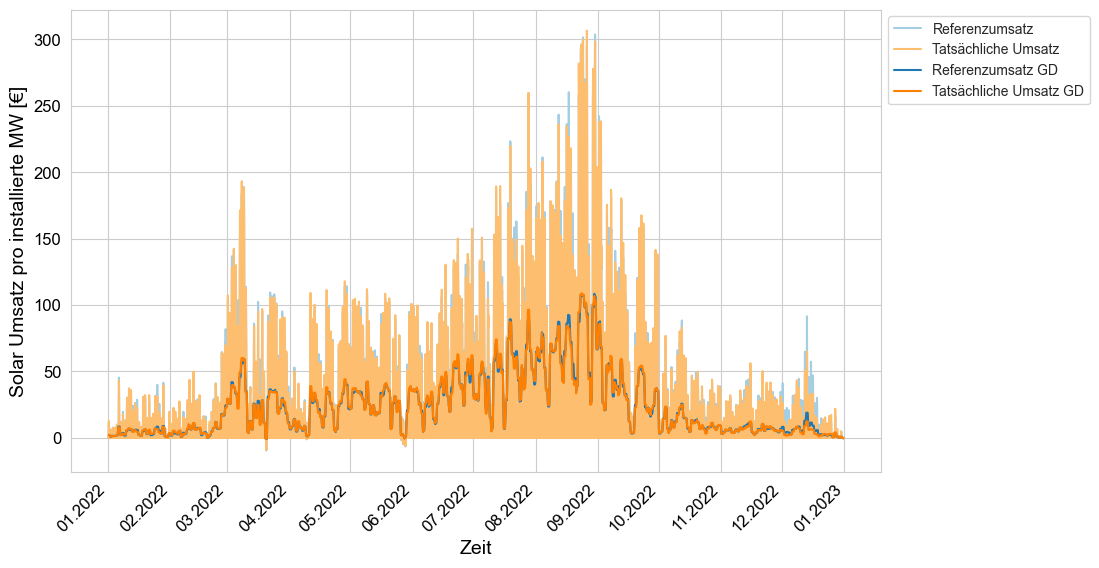

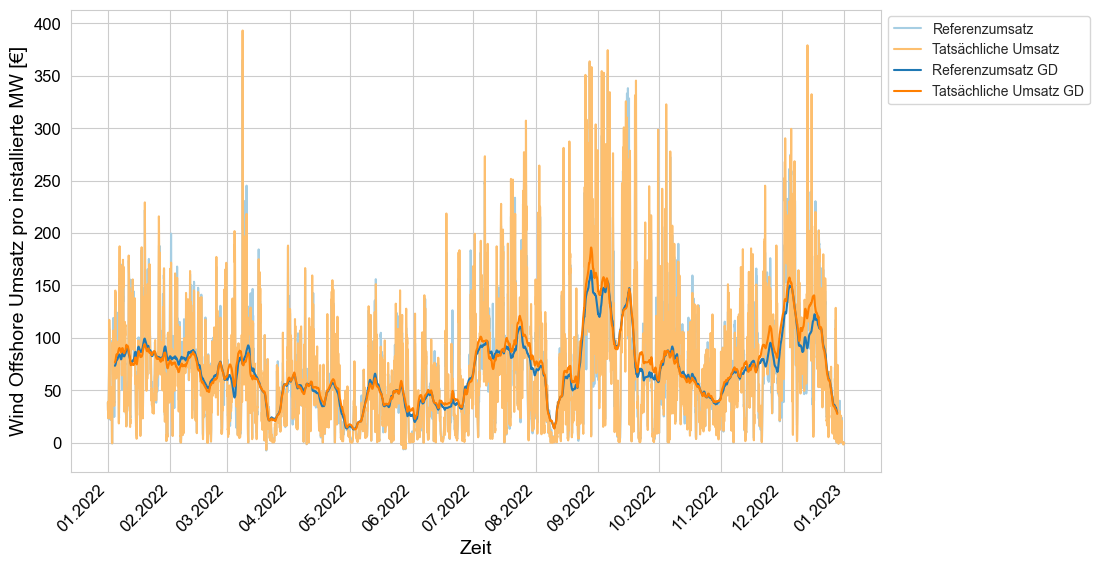

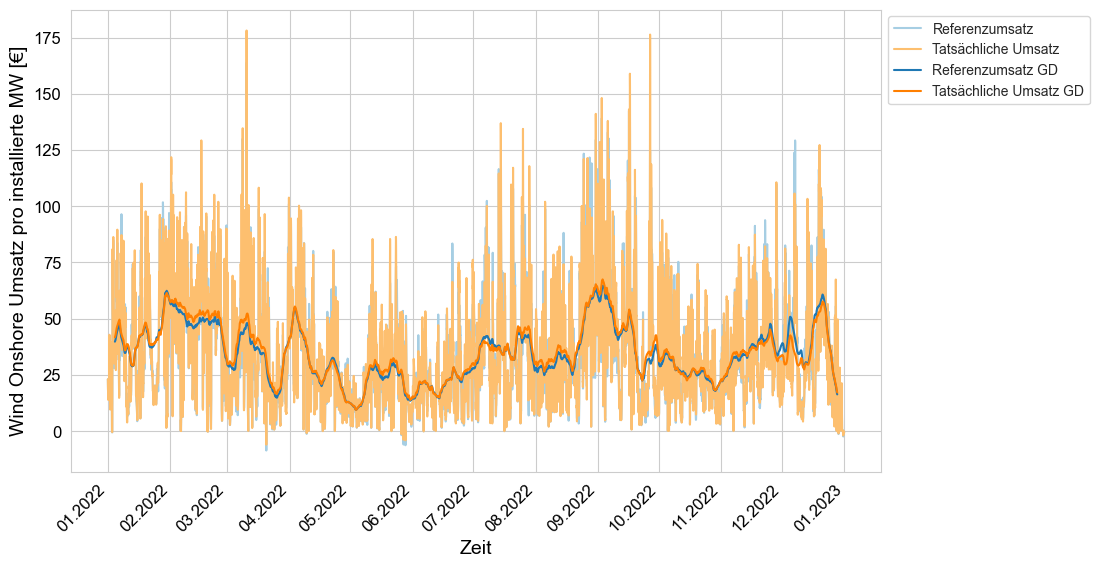

In [8]:
sns.set_style("whitegrid")
colors = sns.color_palette("Paired",8)
font_ax = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 14,}

for rev,res in zip(rev_cols,res_cols):
    plt.figure(figsize=(12, 6))
    plt.plot(df_forec_revenue[rev + ' per MW'], label ='Referenzumsatz', color = colors[0])
    plt.plot(df_actual_revenue[rev + ' per MW'], label ='Tatsächliche Umsatz',color =colors[6])
    plt.plot(df_forec_revenue[rev + ' per MW moving avg.'], label ='Referenzumsatz GD',color = colors[1])
    plt.plot(df_actual_revenue[rev + ' per MW moving avg.'], label ='Tatsächliche Umsatz GD',color = colors[7])
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
    plt.xticks(rotation=45, ha='right', color = 'black', fontsize = 12)
    plt.yticks(color = 'black', fontsize = 12)
    plt.xlabel('Zeit', fontdict=font_ax)
    plt.ylabel(res + ' Umsatz pro installierte MW [€]', fontdict=font_ax)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.subplots_adjust(right=0.8)



## 1.5. Revenue margin associated to Weather risk

In [26]:
#Aggregated Referece revenue

ref_rev = pd.DataFrame(columns=['Referenzumsatz'], index=res_cols) 
for res in res_cols:
    ref_rev.at[res,ref_rev.columns[0]] = df_forec_revenue[res + ' revenue'].sum()
#Aggregated actual revenue

act_rev = pd.DataFrame(columns=['Tatsächliche Umsatz'], index=res_cols) 
for res in res_cols:
    act_rev.at[res,act_rev.columns[0]] = df_actual_revenue[res + ' revenue'].sum()
#Aditional margin from CfD in Mio. EUR

add_margin_cfd = pd.DataFrame(columns=['Wetterrisiko Marge'], index=res_cols)

for res in res_cols:
    margin = act_rev.loc[res].iloc[0] - ref_rev.loc[res].iloc[0]
    print(f'The total margin associated to weather risk for {res} energy is {format_euro(margin)}')

The total margin associated to weather risk for Solar energy is €-48.338.981
The total margin associated to weather risk for Wind Offshore energy is €169.755.736
The total margin associated to weather risk for Wind Onshore energy is €371.539.601


# 2. Auctioned government payments' estimation based on annuitized investment costs
As stated by Schlecht et al. [2], a possible way to determine the constant public payments to generators in a financial CfD can be done through an Action. Here, we consider the RE investment costs and a stochastic margin (on average 5%) as the resulting auctioned hourly public payments.

## 2.1 Annuity calculation

In [32]:
#Investment costs in EUR per MW
inv_cost = pd.DataFrame(columns=['Investitionkosten'], index=res_cols, data=[700000, 3200000, 1400000]) #Taken from Weber et al. [5]

#annuity costs and hourly payments

payments  = pd.DataFrame(columns=['Annuity'], index=res_cols)

annual_interest_rate = 0.047 #TODO check the real value of interest rates and lifetimes for each tech
loan_lifetime_years = 25
monthly_interest_rate = annual_interest_rate / 12
total_payments = loan_lifetime_years * 12

for res in res_cols:
    payments.at[res,payments.columns[0]] = inv_cost.at[res,inv_cost.columns[0]] * (monthly_interest_rate * (1 + monthly_interest_rate)**total_payments) / ((1 + monthly_interest_rate)**total_payments - 1)

#Stochastically define the margin of the auction to be added to the investment costs
m = np.random.normal(5,1)

#hourly government payments to RE producers

payments['hourly payments per MW'] = payments['Annuity']*12/(365*24)*(1+(m/100))
payments.map(format_euro_cents)

,Annuity,hourly payments per MW
Solar,€3.970.72,€5.69
Wind Offshore,€18.151.85,€25.99
Wind Onshore,€7.941.43,€11.37


## 2.2 Final profit margin calculations of financial CfD scenario  

In [33]:
#All values presented in EUR/installed MW

solar, wind_onshore, wind_offshore = [pd.DataFrame(columns=(['actual revenue', 'reference revenue','margin','govt. income', 'net income']), index=df_actual_revenue.index) for _ in range(3)]
res_list = [solar, wind_offshore, wind_onshore]

for res1, res2 in zip(res_list,res_cols):
    res1['actual revenue'] = df_actual_revenue[res2 + ' revenue per MW']
    res1['reference revenue'] = df_forec_revenue[res2 + ' revenue per MW']
    res1['margin'] = res1['actual revenue'] - res1['reference revenue']
    res1['govt. income'] = payments.loc[res2]['hourly payments per MW']
    res1['net income'] = res1['govt. income'] + res1['margin']

#Aggregate for the year

df_final_revenues = pd.DataFrame(columns=solar.columns, index=res_cols)

for row, res in zip(res_cols,res_list):
    for col in df_final_revenues.columns:
        df_final_revenues.at[row,col] = format_euro(res[col].sum()) 
        
df_final_revenues

,actual revenue,reference revenue,margin,govt. income,net income
Solar,€214.523,€215.356,€-833,€49.802,€48.968
Wind Offshore,€618.099,€596.299,€21.800,€227.666,€249.466
Wind Onshore,€306.350,€299.650,€6.700,€99.604,€106.303


# 3. Steel industry subsidies calculation
As stated at the beginning, the steel industry association has been calling for a subsidized price cap (*Brückenstrompreis*). More specifically, they have been calling for a daily cap based on the average price of electricity of a given day [4]. 

## 3.1 daily price cap definition

In [ ]:
#Define dataframe with real prices and daily average prices

df_preis_day = pd.DataFrame(df_preis['price'].groupby(df_preis.index.date).mean())
df_preis_day.rename(columns = {'price':'price_avg'}, inplace=True)
df_preis_full = df_preis.join(df_preis_day.rename(columns = {'price':'price_avg'}), on = 'date')
#Establish a daily maximum value, the so called "Brückenstrompreis"

df_preis_full.loc[df_preis_full['price'] < df_preis_full['price_avg'],'subsidized price'] = df_preis_full['price']
df_preis_full.loc[df_preis_full['price'] >= df_preis_full['price_avg'],'subsidized price'] = df_preis_full['price_avg']


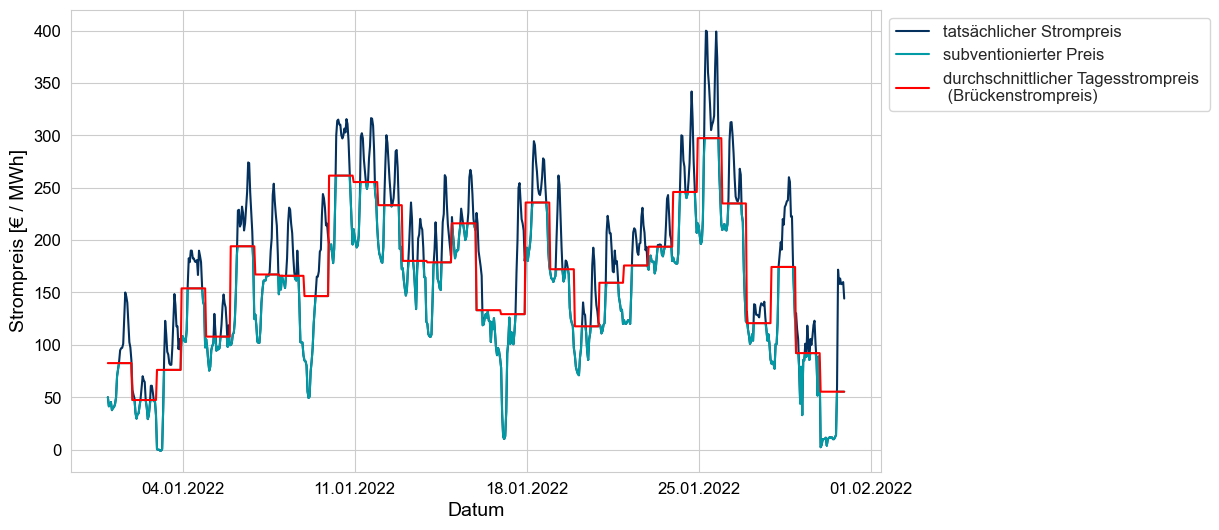

In [14]:
#Visualize capped price for january

sns.set_style("whitegrid")
colors = ['#03305D', '#009BA4']
font_ax = {'family': 'arial',
           'color':  'black',
           'weight': 'normal',
           'size': 14,}


hours = 24*30
plt.figure(figsize=(12, 6))
plt.plot(df_preis_full.head(hours).index,df_preis_full.head(hours)['price'], label= 'tatsächlicher Strompreis', color = colors[0])
plt.plot(df_preis_full.head(hours).index,df_preis_full.head(hours)['subsidized price'], label = 'subventionierter Preis', color=colors[1])
plt.plot(df_preis_full.head(hours).index,df_preis_full.head(hours)['price_avg'], label= 'durchschnittlicher Tagesstrompreis \n (Brückenstrompreis)', color = 'red')

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xticks(ha='center', color = 'black', fontsize = 12)
plt.yticks(color = 'black', fontsize = 12)
plt.xlabel('Datum', fontdict=font_ax)
plt.ylabel('Strompreis [€ / MWh]', fontdict=font_ax)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)

plt.subplots_adjust(right=0.8)



## 3.2 Estimation of electricity consumption
In this case, hourly electricity consumption is based on the assumption of constant steel production rate and a defined consumption rate per ton of produced steel 

In [51]:
#Energy consumption based on production 
tot_prod = 36.8*1e6 #based on Wirtschaftsvereinigung Stahl [6]
energy_cons_pro_ton = 625 #energy consumption per produced steel ton [kWh] based on Wirtschaftsvereinigung Stahl [6]
tot_energy = tot_prod * energy_cons_pro_ton/1000 #[MWh]
hourly_demand = tot_energy/(365*24)

df_steel = pd.DataFrame(index=df_preis_full.index)
df_steel['actual price'] = df_preis_full['price']
df_steel['subsidized price'] = df_preis_full['subsidized price']
df_steel['steel_prod_elec_demand [MWh]'] = hourly_demand
df_steel['real cost'] = df_steel['steel_prod_elec_demand [MWh]'] * df_steel['actual price']
df_steel['subsidized cost'] = df_steel['steel_prod_elec_demand [MWh]'] * df_steel['subsidized price']
df_steel_agg = pd.DataFrame(df_steel[['steel_prod_elec_demand [MWh]', 'real cost', 'subsidized cost']].sum()).T
df_steel_agg['real cost'] = df_steel_agg['real cost'].apply(format_euro)
df_steel_agg['subsidized cost'] = df_steel_agg['subsidized cost'].apply(format_euro)
df_steel_agg

,steel_prod_elec_demand [MWh],real cost,subsidized cost
0,23000000.0,€5.415.261.282,€4.867.298.860


In [16]:
steel_subsidy = df_steel_agg.loc['real cost'].iloc[0] - df_steel_agg.loc['subsidized cost'].iloc[0]
print(f'The total subsidies of electricity price for the steel industry amounts to {"€{:,.0f}".format(steel_subsidy)}')


The total subsidies of electricity price for the steel industry amounts to €547,962,422


## 3.3 Required public investment in RE that would amount to the steel industry's subsidies 
In the following, an estimation of disjunctive investments is presented, meaning the investment in only one of any of the three technologies. 

In [53]:
df_subs_through_res = pd.DataFrame(index=res_cols, columns=['Number of required MW', 'percentage of inst_cap'])

for rev,res in zip(res_list,res_cols):
    df_subs_through_res.at[res,df_subs_through_res.columns[0]] = round(steel_subsidy/rev['actual revenue'].sum())
    df_subs_through_res.at[res,df_subs_through_res.columns[1]] = "{:.2%}".format(df_subs_through_res.at[res,df_subs_through_res.columns[0]] / inst_cap[res].iloc[0])
    
df_subs_through_res
    

,Number of required MW,percentage of inst_cap
Solar,2554,4.40%
Wind Offshore,887,11.39%
Wind Onshore,1789,3.23%


In [18]:
df_subs_through_res = pd.DataFrame(index=res_cols, columns=['Disjunkte Investition [MW]'])

for rev,res in zip(res_list,res_cols):
    df_subs_through_res.at[res,df_subs_through_res.columns[0]] = round(steel_subsidy/(rev['actual revenue'].sum()-rev['govt. income'].sum()))

df_subs_through_res


,Disjunkte Investition [MW]
Solar,3345
Wind Offshore,1419
Wind Onshore,2674


# 4. Literature

1. European Commission (2023b): Proposal for a REGULATION OF THE EUROPEAN PARLIAMENT
AND OF THE COUNCIL amending Regulations (EU) 2019/943 and (EU) 2019/942 as well as
Directives (EU) 2018/2001 and (EU) 2019/944 to improve the Union’s electricity market design.
2. Schlecht, I., Maurer, C. und Hirth, L. (2023): Financial Contracts for Differences
3. Centrum für Europäische Politik (2023): Dekarbonisierung ohne Deindustrialisierung
4. Wirtschaftsvereinigung Stahl (2023): Brückenstrompreis – Investition in einen starken Industriestandort in einer klimaneutralen Zukunft
5. Weber, C., Möst, D. and Fichtner, W. (2022): Economics of Power Systems
6. Wirtschaftsvereinigung Stahl (2022a): Stahl in Deutschland - Zahlen und Fakten. URL: [https://www.stahl-online.de/startseite/stahl-in-deutschland/zahlen-und-fakten/](https://www.stahl-online.de/startseite/stahl-in-deutschland/zahlen-und-fakten/)